In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transforms (resize and normalize if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor()           # Convert to PyTorch tensor
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/sports-classification/train", transform=transform)

# Get class-to-index mapping
print(dataset.class_to_idx)

# Access an image and its label
image, label = dataset[0]

print(label)  # Prints the label index

{'air hockey': 0, 'ampute football': 1, 'archery': 2, 'arm wrestling': 3, 'axe throwing': 4, 'balance beam': 5, 'barell racing': 6, 'baseball': 7, 'basketball': 8, 'baton twirling': 9, 'bike polo': 10, 'billiards': 11, 'bmx': 12, 'bobsled': 13, 'bowling': 14, 'boxing': 15, 'bull riding': 16, 'bungee jumping': 17, 'canoe slamon': 18, 'cheerleading': 19, 'chuckwagon racing': 20, 'cricket': 21, 'croquet': 22, 'curling': 23, 'disc golf': 24, 'fencing': 25, 'field hockey': 26, 'figure skating men': 27, 'figure skating pairs': 28, 'figure skating women': 29, 'fly fishing': 30, 'football': 31, 'formula 1 racing': 32, 'frisbee': 33, 'gaga': 34, 'giant slalom': 35, 'golf': 36, 'hammer throw': 37, 'hang gliding': 38, 'harness racing': 39, 'high jump': 40, 'hockey': 41, 'horse jumping': 42, 'horse racing': 43, 'horseshoe pitching': 44, 'hurdles': 45, 'hydroplane racing': 46, 'ice climbing': 47, 'ice yachting': 48, 'jai alai': 49, 'javelin': 50, 'jousting': 51, 'judo': 52, 'lacrosse': 53, 'log rol

In [3]:
print(image)

tensor([[[0.4510, 0.2314, 0.1922,  ..., 0.1176, 0.1137, 0.1176],
         [0.4941, 0.2314, 0.2157,  ..., 0.1137, 0.1255, 0.1176],
         [0.5020, 0.3843, 0.2392,  ..., 0.1137, 0.1216, 0.1137],
         ...,
         [0.1765, 0.1843, 0.1922,  ..., 0.2510, 0.2706, 0.2627],
         [0.1608, 0.1765, 0.1961,  ..., 0.2627, 0.2706, 0.2627],
         [0.1725, 0.1922, 0.2157,  ..., 0.2706, 0.2706, 0.2627]],

        [[0.2863, 0.0784, 0.0627,  ..., 0.1176, 0.1098, 0.1176],
         [0.3176, 0.0706, 0.0824,  ..., 0.1137, 0.1216, 0.1176],
         [0.3176, 0.2078, 0.0980,  ..., 0.1137, 0.1176, 0.1176],
         ...,
         [0.1922, 0.2000, 0.2078,  ..., 0.2667, 0.2941, 0.2863],
         [0.1765, 0.1922, 0.2118,  ..., 0.2784, 0.2941, 0.2863],
         [0.1882, 0.2078, 0.2353,  ..., 0.2902, 0.2941, 0.2863]],

        [[0.2000, 0.0118, 0.0275,  ..., 0.0706, 0.0941, 0.1098],
         [0.2275, 0.0000, 0.0471,  ..., 0.0745, 0.1020, 0.1098],
         [0.2078, 0.1255, 0.0510,  ..., 0.0745, 0.0980, 0.

## **Plot Images**

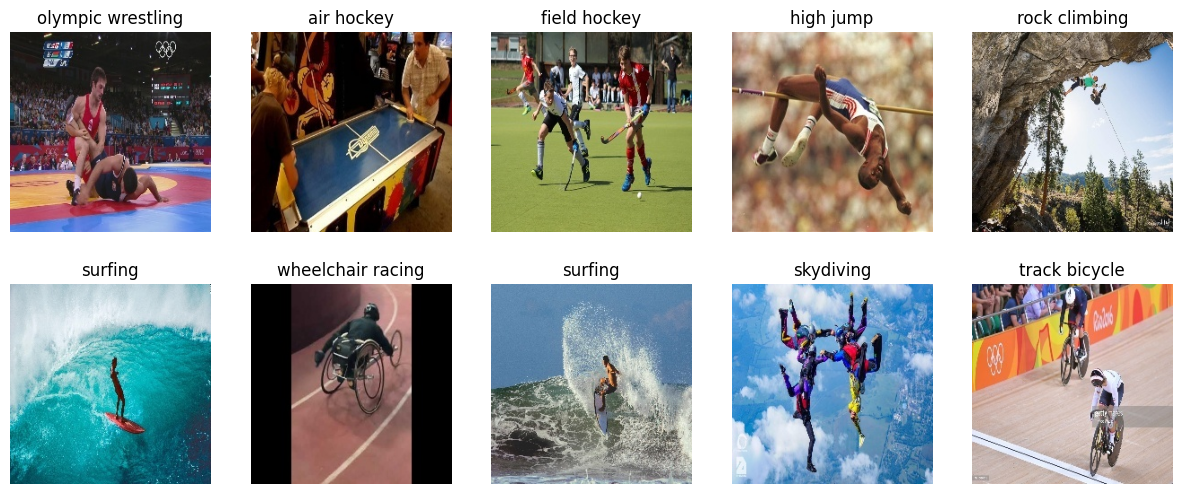

In [4]:
# Select 10 random images
random_indices = random.sample(range(len(dataset)), 10)
random_images = [dataset[i] for i in random_indices]

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (image, label) in zip(axes.flat, random_images):
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(dataset.classes[label])
    ax.axis("off")

plt.show()

## **Transform Images**

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# for validation and Test ( No Augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## **Creating DataLoader**

In [8]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/sports-classification/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='/kaggle/input/sports-classification/valid', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# **Load Pre-Trained Model**

In [9]:
# Load Pretrained Model
model = models.resnet50(pretrained=True)

# Modify Last Layer to Fit Number of Classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))

# Move Model to GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## **Loss and Optimizer**

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [17]:
# Early Stopping Parameters
patience = 3
best_val_loss = np.inf
counter = 0

In [21]:
num_epochs = 50
total_accuracy = []
total_loss = []
validation_loss = []
validation_acc = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_acc = correct / total
    total_accuracy.append(total_accuracy)
    total_loss.append(running_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")

    #validation
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss +=loss
            _, predicted = output.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        acc_val = correct/total
        loss_val = val_loss/len(val_loader)
        validation_acc.append( acc_val)

        validation_loss.append(loss_val)
        print(f"Validation loss : {loss_val: .4f}, Validation Accuracy : {acc_val:.4f}" )


    if running_loss < best_val_loss:
        best_val_loss = running_loss
        counter = 0
    else:
        counter +=1
        if counter > patience:
            print("Early stopping triggered!")
            break

Epoch 1, Loss: 210.9477, Accuracy: 0.8469
Validation loss :  0.3130, Validation Accuracy : 0.8486
Epoch 2, Loss: 212.0974, Accuracy: 0.8460
Validation loss :  0.3320, Validation Accuracy : 0.8475
Epoch 3, Loss: 199.8100, Accuracy: 0.8524
Validation loss :  0.3482, Validation Accuracy : 0.8534
Epoch 4, Loss: 199.8761, Accuracy: 0.8569
Validation loss :  0.3733, Validation Accuracy : 0.8578
Epoch 5, Loss: 188.7404, Accuracy: 0.8613
Validation loss :  0.3788, Validation Accuracy : 0.8623
Epoch 6, Loss: 187.9949, Accuracy: 0.8621
Validation loss :  0.2909, Validation Accuracy : 0.8636
Epoch 7, Loss: 186.0573, Accuracy: 0.8638
Validation loss :  0.3079, Validation Accuracy : 0.8649
Epoch 8, Loss: 179.9537, Accuracy: 0.8661
Validation loss :  0.3245, Validation Accuracy : 0.8676
Epoch 9, Loss: 177.4003, Accuracy: 0.8691
Validation loss :  0.3213, Validation Accuracy : 0.8704
Epoch 10, Loss: 176.8235, Accuracy: 0.8717
Validation loss :  0.3527, Validation Accuracy : 0.8724
Epoch 11, Loss: 174

In [23]:
torch.save(model.state_dict(), "train_model")

In [ ]:
test_dataset = datasets.ImageFolder(root='/kaggle/input/sports-classification/test', transform=val_transforms)